# *In silico* Multi-Objective BO with Odyssey

We are now moving onto the Multi-Objective Bayesian Optimization (MOBO)! Just like our previous exercise in `05_Bayesian_Optimization_Odyssey_InSilico.ipynb`, we will continue to use [**Odyssey**](https://odyssey-51edb0.gitlab.io/). The only difference is that we will now expand on the single-objective opmitization to muti-objective optimization. As usual, you will move on to the PumpBot in the next exercise, so make sure you do proper coding and experiment with parameters in this exercise to make the next one easier. 

Let's start by importing `Odyssey` and some additional packages.

In [1]:
# Odyssey 
from odyssey.mission import Mission # Mission
from odyssey.objective import Objective # Objective
from odyssey.navigators import qNParEGO_Navigator, qEHVI_Navigator # Multi-Objective Navigators
from odyssey.navigators.sampler_navigators import Sobol_Navigator, Grid_Navigator # Sampler

# Other Packages
import torch
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from IPython import display
from warnings import catch_warnings, simplefilter

from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning


/Users/achtu/Library/Caches/pypoetry/virtualenvs/ai-orchestrated-sdl-HM1YmV5R-py3.12/lib/python3.12/site-packages/pyro/ops/stats.py:514: SyntaxWarning: invalid escape sequence '\g'
  """
/Users/achtu/Library/Caches/pypoetry/virtualenvs/ai-orchestrated-sdl-HM1YmV5R-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The key difference in the imported classes are the multi-objective naviators (acquisition functions): `qNParEGO_Navigator` and `qEHVI_Navigator`. These respectively refers **Par**eto **E**fficient **G**lobal **O**ptimization (ParEGO) and **E**xpected **H**ypervolume **I**mprovement (EHVI). 

Note that the prefix `q` in the navigator name represents the batch size, indicating the number of points to be evaluated simultaneously in a parallel fashion. The prefix `N` stands for "noisy", referring to the handling of noise in the objective function of constraints. Therefore, `qNParEGO` is a parallel, noisy version of the `ParEGO` algorithm, for example. We will not be dealing with the batch size, so you do not need to worry about it.

## Exercise 7.1: Multi-Objective Optimization using single input function

As usual, we start with a simple example. This case, we provide you with the objective functions, and you will be trying to find the global minimum of two functions below for $x \in [-5, 5]$.

In [2]:
def first_objective_function(x):
    val = -(torch.sin(x) + torch.sin((10.0 / 3.0) * x))
    return val

In [3]:
def second_objective_function(x):
    val = -(torch.cos((2.0 / 1.0) * x) + torch.cos((10.0 / 3.0) * x))
    return val

Let's visualize the two objective functions to see where the minimum values of the two functions are.

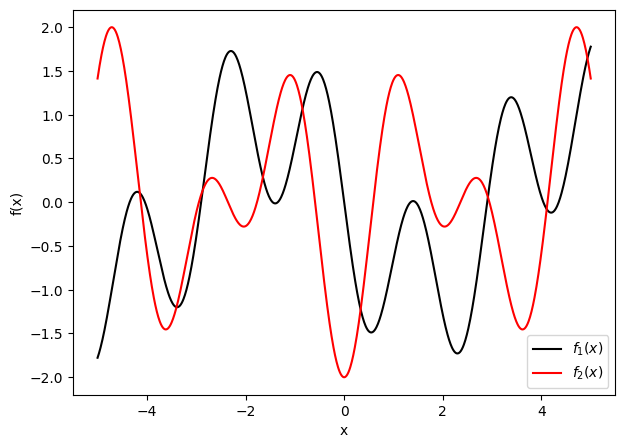

In [4]:
test_X = torch.linspace(-5, 5, 1000)
test_Y1 = first_objective_function(test_X)
test_Y2 = second_objective_function(test_X)


plt.figure(figsize=(7, 5))
plt.plot(test_X, test_Y1, color='black', label=r"$f_1(x)$")
plt.plot(test_X, test_Y2, color='red', label=r"$f_2(x)$")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

Not surprisingly, you can see that the global minima of the two objective functions do not coincide, meaning that you cannot simultaneously minimize both $f_1(x)$ and $f_2(x)$. It is time to apply what you learned about the multi-objective optimization. 

Let's use MOBO to find the optimal trade-offs between the two conflicting objectives! We start by defining the two objectives below. 

In [5]:
objectives = [Objective(func=first_objective_function),
              Objective(func=second_objective_function)]

We now initialize our "mission" where we perform the minimization of $f_1(x)$ and $f_2(x)$ for $x \in [-5, 5]$. Note that `func` and `maneuvers` are list of length two since we optimize two objectives. 

In [6]:
param_space = [(-5.0, 5.0)]

mission = Mission(name="MOO minimizing two functions",
                  funcs=objectives,
                  maneuvers=['descend', 'descend'],
                  envelope=param_space)

The next step is to specify how we would like to navigate through our search space by selecting the `Navigator`. We demonstrate how to use `qNParEGO_Navigator` that scalarizaes the multi-objective into a single-objective problem. 

<div class="alert alert-block alert-info">
<b>Note:</b> Aftr you run this simple tutorial, change to 'qEHVI_Navigator' and re-run the example and compare its performance/behavior.
</div>

In [7]:
num_init = 5
navigator = qNParEGO_Navigator(mission=mission,
                               num_init_design=num_init,
                               input_scaling=False,
                               data_standardization=False,
                               init_method=Sobol_Navigator(mission=mission),
                               acq_function_params={}
)

tensor([[4.4483]])
tensor([[0.1899]])
tensor([[1.0078]])
tensor([[-1.6219]])
tensor([[-2.2189]])
Succesfully appended {'param_1': [4.4482980389148, 0.189873231574893, 1.007773233577609, -1.6218626499176025, -2.2188642900437117], 'objective_1': [0.19439820457742052, -0.780228648938677, -0.629708328969605, 0.22988748272101067, 1.6942930057047505], 'objective_2': [1.5006422372806734, -1.7350678694111854, 1.4066396197604516, 0.35531041607855274, -0.17072633404043014], 'creation_timestamp': '18-06-25 09:10:58'} to missionlogs/MOO minimizing two functions-180625_091019.csv


/Users/achtu/Library/Caches/pypoetry/virtualenvs/ai-orchestrated-sdl-HM1YmV5R-py3.12/lib/python3.12/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/achtu/Library/Caches/pypoetry/virtualenvs/ai-orchestrated-sdl-HM1YmV5R-py3.12/lib/python3.12/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.1417]), std = tensor([0.9831])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/achtu/Library/Caches/pypoetry/virtualenvs/ai-orchestrated-sdl-HM1YmV5R-py3.12/lib/python3.12/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/achtu/Library/Caches/pypoetry

The function below is used to plot Pareto Front.

In [8]:
def plot_progress():    
    plt.figure(figsize=(10, 6))
    pareto = mission.display_Y[is_non_dominated(Y=mission.display_Y, maximize=False)]
    pareto_sorted = pareto.cpu().numpy()
    pareto_front = pareto_sorted[pareto_sorted[:, 0].argsort()]

    plt.plot(pareto_front[:, 0], pareto_front[:, 1], label='qNParEGO Pareto Front', marker='+', markersize=10, color='royalblue', linestyle='-')
    plt.scatter(mission.display_Y[:, 0].cpu(), mission.display_Y[:, 1].cpu(), label='qNParEGO Samples', alpha=0.5)

    plt.xlabel(r'$f_1(x)$')
    plt.ylabel(r'$f_2(x)$')
    plt.title('Pareto Front using qNParEGO')
    plt.legend()
    plt.show()

Now, let's start the MOBO loop!

You are **strongly** encouraged to experiment with the parameters.

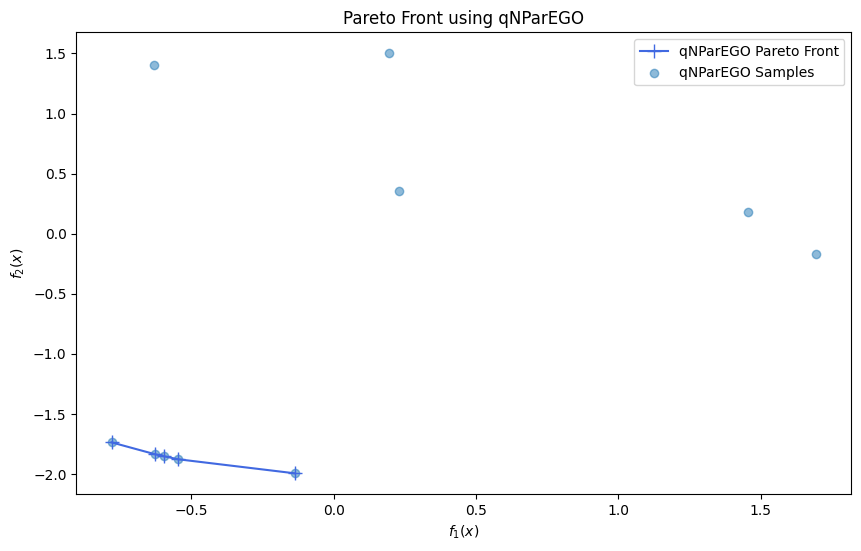

Iteration 5: Hypervolume = 0.0000


KeyboardInterrupt: Interrupted by user

In [9]:
num_iter = 15
opt_samples = len(mission.display_X) - num_init
ref_point = torch.tensor([5.0, 5.0])


while opt_samples < num_iter:
    with catch_warnings() as w:
        simplefilter('ignore')
        trajectory = navigator.trajectory()
        observation = navigator.probe(input_data=trajectory, init=False)
        navigator.relay(trajectory, observation)
        navigator.upgrade()

    # Compute Pareto front and hypervolume
    pareto_mask = is_non_dominated(Y=mission.display_Y, maximize=False)
    pareto_Y = mission.display_Y[pareto_mask]

    # Update training data
    partitioning = NondominatedPartitioning(ref_point=ref_point, Y=pareto_Y)
    hypervolume = partitioning.compute_hypervolume().item()

    opt_samples = len(mission.display_X) - num_init
    
    display.clear_output(wait=True) # This will help you remove figures as you go
    plot_progress()
    print(f"Iteration {opt_samples}: Hypervolume = {hypervolume:.4f}")
    input('Press Enter to proceed.')
    
print(f"Finished optimization.")


## Exercise 7.2: Let's combine color mixing with different pH values

Now you got a good taste of how to perform MOBO using Odyssey. It is time to get back to the color mixing. 

We will build upon the previous notebooks to perform inSilico color mixing, so we only introduce you to the "new" features that are relevant for MOBO. In this case, we will utilize the functionality of the `SilicoPumpController` to assign a pH value for each of the red, green, blue, and yellow solution. It can calculate the pH of the solution mixtures, in addition to the resulting color. 

Reusing your code from the previous *in silico* exercises as much as you can to figure out how to perform MOBO. 
 

In [10]:
# Pump Controller
from pump_controller import SilicoPumpController

In [11]:
# Let's have some noise to keep it real.
silicobot = SilicoPumpController(noise_std = 3)

We can introduce the pH value of each of the stock solution using `set_ph_coefficient` method. Let's assume the following pH values:
* red: 7.0
* green: 10.0
* blue: 4.0
* yellow: 3.0

In [12]:
silicobot.set_ph_coefficient(r=7.0, g=10.0, b=4.0, y=3.0)

Now, let's test how it behaves. Let's mix half red and half green to make yellow. Since the pH value of red and green are 7.0 and 10.0, respectively, the resulting solution should have the pH level of 8.5.

In [13]:
silicobot.mix_color(col_list=[0.5, 0.5, 0.0, 0.0], ph=True)

(array([126.423765  , 128.88514178,   0.        ]), 8.446188250065475)

You can see that the resulting RGB corresponds to the yellow color (equal parts of red and green), and you get the pH value of 8.5. Of course, with some errors due to the `noise_std` value. 

Here are 3 different sets of colors and pH values. Try to obtain them using MOBO feature of Odyssey. Be sure to tinker with the notebook to see how you can extract the key information such as the ratios of `r`, `g`, `b`, and `y` to obtain the "best" mixtures.

Have fun!

In [14]:
target_color_1 = [125., 125., 0.]
target_pH_1 = 3.

In [15]:
target_color_2 = [83., 156., 72.]
target_pH_2 = 9.

In [16]:
target_color_3 = [145., 120., 100.]
target_pH_3 = 7.

In [ ]:
# place for your code

In [ ]:
# place for your code

In [ ]:
# place for your code.  Add more as needed.